In [89]:
import lightning as pl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader,random_split
import torchvision.datasets as datasets
import torch.nn.functional as F
from torchvision.datasets import MNIST
import os

In [90]:
BATCH_SIZE = 128
random_seed = 50
torch.manual_seed(random_seed)

In [91]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]
        )
        
    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)
        
    def setup(self, stage=None):
        if stage=="fit" or None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])
            
        if stage=="test" or None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
            
    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size) #shuffle = True
    
    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)
    
    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)

In [92]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1), # 28x28 -> 14x14
            nn.ReLU(),
            
            nn.Conv2d(64, 128, 4, 2, 1), # 14x14 -> 7x7
            nn.ReLU(),
            
            nn.Conv2d(128, 256, 4, 2, 1), # 7x7 -> 3x3
            nn.ReLU(),
            
            nn.Conv2d(256, 1, 3, 1, 0), # 3x3 -> 1x1
            nn.Sigmoid() # 0~1 aka fake or real
        )
        
    def forward(self, x):
        output = self.model(x)
        return output.view(-1)

In [93]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256*7*7),
            nn.ReLU(),
            
            nn.Unflatten(1, (256, 7, 7)),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1), # 7x7 -> 14x14
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 1, 4, 2, 1), # 14x14 -> 28x28
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [94]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False
        
        
        self.generator = Generator(self.hparams.latent_dim)
        self.discriminator = Discriminator()
        
        self.validation_z = torch.randn(6, self.hparams.latent_dim)
        
    def forward(self, z):
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx):
        real, _ = batch # real images, labels
        
        generator_optimizer, discriminator_optimizer = self.optimizers()
        
        z = torch.randn(real.shape[0], self.hparams.latent_dim).to(self.device)
        
        ############################
        # (1) Train Generator
        ############################
        
        fake_images = self.generator(z)
            
        y_hat = self.discriminator(fake_images)
        y = torch.ones_like(y_hat).to(self.device)
            
        generator_loss = self.adversarial_loss(y_hat, y)
        
        generator_optimizer.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()
        
        ############################
        # (2) Train Discriminator
        ############################
            
        ############################
        # Train on FAKE images
        ############################
        
        fake_images = self.generator(z)
        
        y_hat = self.discriminator(fake_images.detach())
        y = torch.zeros_like(y_hat).to(self.device)
        
        loss_fake = self.adversarial_loss(y_hat, y)
        
        ############################
        # Train on REAL images
        ############################
        
        y_hat = self.discriminator(real)
        y = torch.ones_like(y_hat).to(self.device)
        
        loss_real = self.adversarial_loss(y_hat, y)
        
        ############################
        # Combine losses
        ############################
        
        discriminator_loss = (loss_fake + loss_real) / 2
        
        discriminator_optimizer.zero_grad()
        discriminator_loss.backward()
        discriminator_optimizer.step()
        
        
        self.log_dict({"discriminator_loss": discriminator_loss, "generator_loss": generator_loss}, prog_bar=True, logger=True)
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        
        generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr)
        discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        
        return [generator_optimizer, discriminator_optimizer], []
    
    def plot_images(self):
        z = self.validation_z.to(self.device)
        samples = self.generator(z).cpu()
        grid = torchvision.utils.make_grid(samples).permute(1, 2, 0)
        plt.imshow(grid)
        plt.show()
    
    def on_epoch_end(self):
        self.plot_images()

In [95]:
data_module = MNISTDataModule(data_dir="data/", batch_size=BATCH_SIZE)
model = GAN()

In [96]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 1.8 M 
1 | discriminator | Discriminator | 659 K 
------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.810     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 430/430 [00:48<00:00,  8.87it/s, v_num=3, discriminator_loss=0.0216, generator_loss=4.880] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 430/430 [00:48<00:00,  8.84it/s, v_num=3, discriminator_loss=0.0216, generator_loss=4.880]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


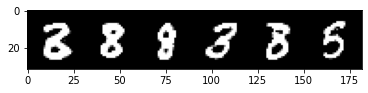

In [97]:
model.plot_images()